# Part IV. Training on multiple years (bigger than memory)

**Author:** Eli Holmes (NOAA)

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/ocean-satellite-tools/mind-the-chl-gap/blob/main/book/notebooks/CHL_prediction_CNN_Part_4.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> [![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link]

[download-link]: https://ocean-satellite-tools.github.io/mind-the-chl-gap/_static/CHL_prediction_CNN_Part_4.ipynb
[colab-link]: https://colab.research.google.com/github/ocean-satellite-tools/mind-the-chl-gap/blob/main/book/notebooks/CHL_prediction_CNN_Part_4.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/ocean-satellite-tools/mind-the-chl-gap/main/book/notebooks/CHL_prediction_CNN_Part_4.ipynb

::: {.callout-note}
# Run this with GPU

You can run in Colab if you don't have GPU access. Click the "Open in Colab" button above. Sign in with a Google Account. You get like 100 hours of compute a month for free.

To get GPU in Colab, go to Edit > Notebook Settings  and select GPU. Then uncomment the `!pip` line below to install the needed libraries.
:::

Now we will put it all together and train on multiple years.

**TO DO** Get rid of days will lots of NaN in CHL. > 832

::: {.callout-note}
# Running on the JupyterHub

Make sure to choose a GPU instance. It is wise to shutdown all the kernels before running the code to make sure you don't run out of memory. Kernel > Shutdown All Kernels
:::

## Load the libraries

In [35]:
# Uncomment this line and run if you are in Colab; leave in the !. That is part of the cmd
# !pip install zarr gcsfs xbatcher --quiet

In [2]:
# --- Core data handling libraries ---
import xarray as xr       # for working with labeled multi-dimensional arrays
import numpy as np        # for numerical operations on arrays
import dask.array as da   # for lazy, parallel array operations (used in xarray backends)

# --- Plotting ---
import matplotlib.pyplot as plt  # for creating plots

import xbatcher

# --- TensorFlow setup ---
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # suppress TensorFlow log spam (0=all, 3=only errors)

import tensorflow as tf  # main deep learning framework

# --- Keras (part of TensorFlow): building and training neural networks ---
from keras.models import Sequential          # lets us stack layers in a simple linear model
from keras.layers import Conv2D              # 2D convolution layer — finds spatial patterns in image-like data
from keras.layers import BatchNormalization  # stabilizes and speeds up training by normalizing activations
from keras.layers import Dropout             # randomly "drops" neurons during training to reduce overfitting
from keras.callbacks import EarlyStopping    # stops training early if validation loss doesn't improve

2025-06-21 02:26:35.210701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-21 02:26:35.228670: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-21 02:26:35.234116: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## See what machine we are on

In [3]:
# list all the physical devices
physical_devices = tf.config.list_physical_devices()
print("All Physical Devices:", physical_devices)

# list all the available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Print infomation for available GPU if there exists any
if gpus:
    for gpu in gpus:
        details = tf.config.experimental.get_device_details(gpu)
        print("GPU Details:", details)
else:
    print("No GPU available")

All Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU Details: {'compute_capability': (7, 5), 'device_name': 'Tesla T4'}


# Load data

We definitely need to use `open_zarr()` so that our data is identified as dask arrays.

In [4]:
# load full dataset 1997 to 2022 from Google bucket
# chunked into 100 day chunks (64, 64 lat/lon)
dataset = xr.open_zarr(
    "gcs://nmfs_odp_nwfsc/CB/mind_the_chl_gap/cnn_tutorial", 
    storage_options={"token": "anon"}, 
    consolidated=True
)

## Set up our train, validation and test datasets for xbatcher

xbatcher requires that we return xarray Datasets, like `dataset` above, with our input variables (`sst`, `so`, etc) and `y` ready for sending to TensorFlow. We compute the normalization metrics (`X_mean` `X_std`) within it and return it for use later (e.g. for validation and test data). 

In [5]:
import numpy as np
import dask.array as da
import xarray as xr

def time_series_split_for_xbatcher(
    data, num_var, cat_var=None, split_ratio=(0.7, 0.2, 0.1), seed=42,
    X_mean=None, X_std=None, sample_frac=None
):
    """
    Splits time indices randomly into train/val/test for xbatcher.
    Replaces NaNs, and normalizes numerical variables if mean/std are provided.
    Downsampling happens before normalization so stats match the final training data.

    Parameters:
        data: xarray.Dataset with 'time' dimension
        num_var: list of numerical variable names
        cat_var: list of categorical variable names (no normalization)
        split_ratio: tuple of train, val, test split ratios
        seed: random seed
        X_mean, X_std: optional normalization stats
        sample_frac: optional float (0, 1] to randomly downsample splits

    Returns:
        train_ds, val_ds, test_ds, full_ds: datasets ready for xbatcher
        X_mean, X_std: used for normalization
    """
    if cat_var is None:
        cat_var = []
    output_var = ["y"]

    time_dim = "time"
    if time_dim not in data.dims:
        raise ValueError("Dataset must contain a 'time' dimension.")

    time_len = data.sizes[time_dim]
    rng = np.random.default_rng(seed)
    all_indices = rng.choice(time_len, size=time_len, replace=False)

    train_end = int(split_ratio[0] * time_len)
    val_end = int((split_ratio[0] + split_ratio[1]) * time_len)
    train_idx = np.sort(all_indices[:train_end])
    val_idx = np.sort(all_indices[train_end:val_end])
    test_idx = np.sort(all_indices[val_end:])

    def downsample_idx(idx):
        if sample_frac is not None and len(idx) > 0:
            n_sample = max(1, int(sample_frac * len(idx)))
            return np.sort(rng.choice(idx, size=n_sample, replace=False))
        return idx

    train_idx = downsample_idx(train_idx)
    val_idx = downsample_idx(val_idx)
    test_idx = downsample_idx(test_idx)

    train_data = data.isel(time=train_idx)

    # Compute normalization stats if not provided
    if num_var:
        if X_mean is None or X_std is None:
            stacked = da.stack([train_data[v].data for v in num_var], axis=-1)
            X_mean = da.nanmean(stacked, axis=(0, 1, 2)).compute()
            X_std = da.nanstd(stacked, axis=(0, 1, 2)).compute()
        X_std_safe = da.where(X_std == 0, 1.0, X_std)

    def normalize_and_fill(ds):
        ds_copy = ds.copy()
        for i, var in enumerate(num_var):
            v = (ds[var] - X_mean[i]) / X_std_safe[i]
            ds_copy[var] = xr.DataArray(
                da.nan_to_num(v.data), dims=ds[var].dims, coords=ds[var].coords
            )
        for var in cat_var + output_var:
            ds_copy[var] = xr.DataArray(
                da.nan_to_num(ds[var].data), dims=ds[var].dims, coords=ds[var].coords
            )
        return ds_copy

    train_ds = normalize_and_fill(data.isel(time=train_idx))
    val_ds = normalize_and_fill(data.isel(time=val_idx))
    test_ds = normalize_and_fill(data.isel(time=test_idx))
    full_ds = normalize_and_fill(data)

    return train_ds, val_ds, test_ds, full_ds, X_mean, X_std


## Set up train, validation and test years

I will use different years for each.

In [7]:
# Define variables
input_vars = ["sst", "so", "sin_time", "cos_time", "ocean_mask"]
output_vars = ["y"]
num_var = ["sst", "so"]
cat_var = ["sin_time", "cos_time", "ocean_mask"]

In [8]:
train_yrs = [2015, 2020]
train_years = dataset.sel(time=dataset.time.dt.year.isin(train_yrs))
# Split the dataset using your function
train_ds, _, _, _, X_mean, X_std  = time_series_split_for_xbatcher(
    data=train_years,
    split_ratio=(1.0, 0.0, 0.0),
    num_var=num_var,
    cat_var=cat_var,
    sample_frac = 0.5
)

In [9]:
X_mean

array([301.79614 ,  35.002277], dtype=float32)

In [10]:
val_yrs = [2014, 2019]
val_years = dataset.sel(time=dataset.time.dt.year.isin(train_yrs))
_, val_ds, _, _, X_mean, X_std  = time_series_split_for_xbatcher(
    data=train_years,
    split_ratio=(0.0, 1.0, 0.0),
    num_var=num_var,
    cat_var=cat_var,
    sample_frac = 0.25,
    X_mean=X_mean, X_std=X_std
)

## Set up xbatcher

In [12]:
from xbatcher import BatchGenerator

# Use the whole field
input_dims = {"time": 30, "lat": 149, "lon": 181}
input_overlap = {"time": 0, "lat": 0, "lon": 0}

# Create batch generators
train_gen = BatchGenerator(
    train_ds[input_vars + output_vars], 
    input_dims=input_dims, input_overlap=input_overlap)
val_gen = BatchGenerator(
    val_ds[input_vars + output_vars], 
    input_dims=input_dims, input_overlap=input_overlap)

## Set up generator functions to create numpy arrays

In [13]:
# Generator: yield individual time slices for batches
input_shape = (input_dims["lat"], input_dims["lon"], len(input_vars))
output_shape = (input_dims["lat"], input_dims["lon"], 1)

def train_gen_tf_batches():
    for batch in train_gen:
        time_len = batch["y"].sizes["time"]
        for t in range(time_len):
            x = np.stack([
                batch[var].isel(time=t).data if "time" in batch[var].dims else batch[var].data
                for var in input_vars
            ], axis=-1).astype(np.float32)  # (xx, xx, n_features)
            y = batch["y"].isel(time=t).data[..., np.newaxis].astype(np.float32)  # (xx, xx, 1)
            yield x, y

def val_gen_tf_batches():
    for batch in val_gen:
        time_len = batch["y"].sizes["time"]
        for t in range(time_len):
            x = np.stack([
                batch[var].isel(time=t).data if "time" in batch[var].dims else batch[var].data
                for var in input_vars
            ], axis=-1).astype(np.float32)
            y = batch["y"].isel(time=t).data[..., np.newaxis].astype(np.float32)
            yield x, y


train_dataset_from_gen = tf.data.Dataset.from_generator(
    train_gen_tf_batches,
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=output_shape, dtype=tf.float32),
    )
)

val_dataset_from_gen = tf.data.Dataset.from_generator(
    val_gen_tf_batches,
    output_signature=(
        tf.TensorSpec(shape=input_shape, dtype=tf.float32),
        tf.TensorSpec(shape=output_shape, dtype=tf.float32),
    )
)

### Final prep of dataset for TensorFlow

We are not trying to preserve temporal information since we are predicting chlorophyll from same day SST and salinity. So we shuffle() to make sure that everything is i.i.d. for TensorFlow.

* shuffle() adds randomness within the training batches
* Prevents batch-to-batch correlation
* Improves model convergence and generalization

The max shuffle would be the length of the training data per batch up to about 1000-2000. But if the dataset if very large, that would be a lot of overhead and not necessary. In the pper end 10 x number of batches. In our case, the generator yields one sample per time step, so the total training samples ≈ `len(train_gen) × input_dims["time"]`

In [14]:
print("Number of batches in training set:", len(train_gen))
print("Max shuffle size:", len(train_gen) * input_dims["time"])

Number of batches in training set: 12
Max shuffle size: 360


Using `.repeat()`. I had to add this when using a generator and specify the training steps per batch. Otherwise, TensorFlow was struggling during the first pass to figure out how much data to use and wasn't resetting the generator (to give a new set of data) properly.

In [15]:
# you might need to tweak this
BATCH_SIZE = 8
SHUFFLE_N = 100
train_dataset = train_dataset_from_gen.shuffle(SHUFFLE_N).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset_from_gen.batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)


In [16]:
%%time
# check that shape is (BATCH_SIZE, 149, 181, 5)
for x, y in train_dataset.take(1):
    print("Train x shape:", x.shape)
    print("Train y shape:", y.shape)

Train x shape: (8, 149, 181, 5)
Train y shape: (8, 149, 181, 1)
CPU times: user 3.44 s, sys: 672 ms, total: 4.11 s
Wall time: 6.31 s


## Let's build the model

We build a simple 3-layer CNN model. Each layer preserves the (lat, lon) shape and learns filters to extract spatial patterns. 

In [17]:
from keras.models import Sequential
from keras.layers import Input, Conv2D, BatchNormalization, Dropout

def create_model_CNN(input_shape):
    """
    Create a simple 3-layer CNN model for gridded ocean data.

    Parameters
    ----------
    input_shape : tuple
        The shape of each sample, e.g., (149, 181, 2)

    Returns
    -------
    model : keras.Model
        CNN model to predict CHL from SST and salinity
    """
    model = Sequential()

    # Input layer defines the input dimensions for the CNN
    model.add(Input(shape=input_shape))

    # Layer 1 — learns fine-scale 3x3 spatial features
    # Let the model learn 64 different patterns (filters) in the data at this layer.
    # activation relu is non-linearity
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 2 — expands context to 5x5; combines fine features into larger structures
    # Reduce the number of patterns (filters) so we gradually reduce model complexity
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    # Layer 3 — has access to ~7x7 neighborhood; outputs CHL prediction per pixel
    # Combines all the previous layer’s features into a CHL estimate at each pixel
    # 1 response (chl) — hence, 1 prediction pixel = filter
    # linear since predicting a real continuous variable (log CHL)
    model.add(Conv2D(filters=1, kernel_size=(3, 3), padding='same', activation='linear'))

    return model

## Let's train the model

Because we are working in batches that are chunks of our training set, we only load in a small bit into memory, process that, release the memory and go to the next chunk. This is slow but make sure we can work with larger than memory data.

We load in this
8 × (149 × 181 × n_features + 149 × 181 × 1) × 4 bytes (float32)
≈ a few tens of MB per batch, depending on n_features.

We could do bigger (we have more memory) but this shows the proof of concept.

In [19]:
model = create_model_CNN(input_shape)
model.compile(optimizer='adam', loss='mae', metrics=['mae'])

# Set up early stopping to prevent overfitting
early_stop = EarlyStopping(
    patience=10,              # Stop if validation loss doesn't improve for 10 epochs
    restore_best_weights=True  # Revert to the model weights from the best epoch
)

TRAIN_STEPS_PER_EPOCH = len(train_gen) * input_dims["time"] // BATCH_SIZE
VAL_STEPS_PER_EPOCH = len(val_gen) * input_dims["time"] // BATCH_SIZE

history = model.fit(
    train_dataset,
    epochs=50,                    # Maximum number of training epochs
    steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
    validation_data=val_dataset, # Use validation data during training
    validation_steps=VAL_STEPS_PER_EPOCH,
    callbacks=[early_stop],      # Stop early if no improvement
)

Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 21s 348ms/step - loss: 1.1818 - mae: 1.1818 - val_loss: 0.8262 - val_mae: 0.8262
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 352ms/step - loss: 0.6575 - mae: 0.6575 - val_loss: 0.6876 - val_mae: 0.6876
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 361ms/step - loss: 0.3969 - mae: 0.3969 - val_loss: 0.6155 - val_mae: 0.6155
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 338ms/step - loss: 0.3402 - mae: 0.3402 - val_loss: 0.5467 - val_mae: 0.5467
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - loss: 0.3211 - mae: 0.3211 - val_loss: 0.4450 - val_mae: 0.4450
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 289ms/step - loss: 0.3033 - mae: 0.3033 - val_loss: 0.3884 - val_mae: 0.3884
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - loss: 0.2892 - mae: 0.2892 - val_loss: 0.3564 - val_mae: 0.3564
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 232ms/step - loss: 0.2771 - mae: 0.2771 - val_loss: 0.3057 - val_mae: 0.3057
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 15s 233ms/

## Plot training & validation loss values

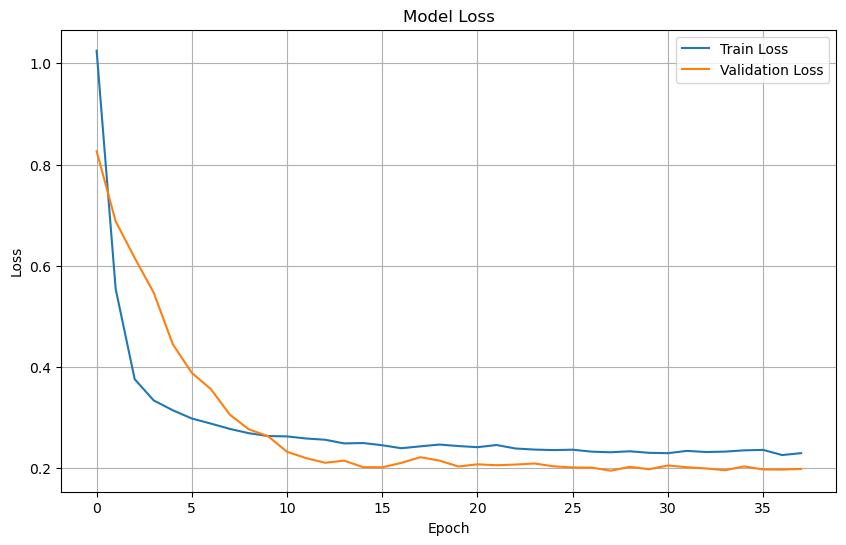

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Plot all months

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_true_vs_predicted(data, year, model, X_mean, X_std, num_var, cat_var):
    """
    Plot true vs predicted output for first available day of each month in data_test.

    Parameters:
        data (xarray.Dataset): Contains variables 'y', 'ocean_mask', and coords 'lat', 'lon', 'time'
        year (string in format XXXX): The year to use.
        model (tf.keras.Model): Trained model with a .predict() method
        X_mean (np.ndarray): mean from the model training data (num_vars only)
        X_std (np.ndarray): std from the model training data
        num_var (np.ndarry): The variables to be standardized with `X_mean` and `X_std`
        cat_var (np.ndarry): The variables to be included in X, y but not standardized.
    """
    # Split the dataset to get full_ds
    _, _, _, year_ds, _, _ = time_series_split_for_xbatcher(
        data=data.sel(time=year),
        num_var=num_var,
        cat_var=cat_var,
        X_mean=X_mean,
        X_std=X_std,
    )

    # Get available time points and group by month
    available_dates = pd.to_datetime(year_ds.time.values)
    monthly_dates = (
        pd.Series(available_dates)
        .groupby([available_dates.year, available_dates.month])
        .min()
        .sort_values()
    )
    n_months = len(monthly_dates)

    # lat/lon info
    lat = year_ds.lat.values
    lon = year_ds.lon.values
    extent = [lon.min(), lon.max(), lat.min(), lat.max()]
    flip_lat = lat[0] > lat[-1]
    land_mask = ~year_ds["ocean_mask"].values.astype(bool)

    # Create figure and axes
    fig, axs = plt.subplots(n_months, 2, figsize=(7, 2 * n_months), constrained_layout=True)

    for i, date in enumerate(monthly_dates):
        # Select dataset for this date
        ds_at_time = year_ds.sel(time=np.datetime64(date))

        # Prepare model input: stack input variables into (lat, lon, n_features)
        input_data = np.stack([
            ds_at_time[var].values for var in input_vars
        ], axis=-1)

        # Predict: shape (lat, lon)
        predicted_output = model.predict(input_data[np.newaxis, ...])[0, ..., 0]

        # True output
        true_output = data["y"].sel(time=np.datetime64(date)).values

        # Mask land
        predicted_output[land_mask] = np.nan
        true_output[land_mask] = np.nan

        # Flip latitude if needed
        if flip_lat:
            true_output = np.flipud(true_output)
            predicted_output = np.flipud(predicted_output)

        # Shared color scale
        vmin = np.nanpercentile([true_output, predicted_output], 5)
        vmax = np.nanpercentile([true_output, predicted_output], 95)

        # Compute R²
        from sklearn.metrics import r2_score
        true_flat = true_output.flatten()
        pred_flat = predicted_output.flatten()
        valid_mask = ~np.isnan(true_flat) & ~np.isnan(pred_flat)
        r2 = r2_score(true_flat[valid_mask], pred_flat[valid_mask])

        # Plot true
        axs[i, 0].imshow(true_output, origin='lower', extent=extent,
                         vmin=vmin, vmax=vmax, cmap='viridis',
                         aspect='equal')
        axs[i, 0].set_title(f"{date.strftime('%b')} — True", fontsize=10)
        axs[i, 0].axis('off')

        # Plot predicted with R²
        axs[i, 1].imshow(predicted_output, origin='lower', extent=extent,
                         vmin=vmin, vmax=vmax, cmap='viridis', 
                         aspect='equal')
        axs[i, 1].set_title(f"{date.strftime('%b')} — Pred\n$R^2$ = {r2:.2f}", fontsize=10)
        axs[i, 1].axis('off')

    plt.suptitle(f'CHL: True vs Predicted (log scale) — {year}', fontsize=16)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


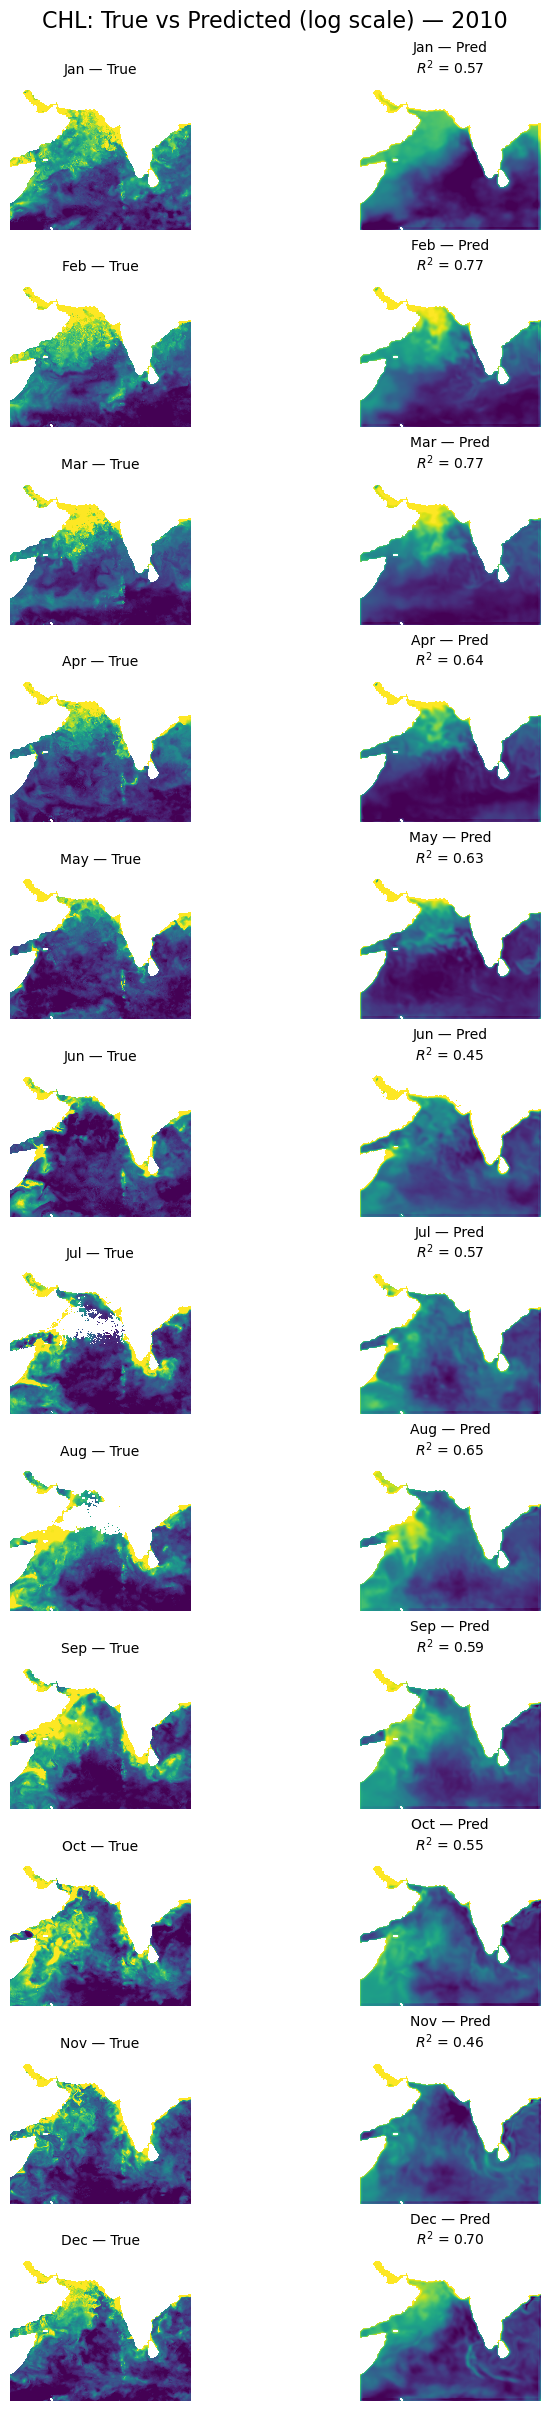

In [26]:
plot_true_vs_predicted(dataset, "2010", model, X_mean, X_std, num_var, cat_var)

## Comparing fits with metrics

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error
import calendar

def plot_metric_by_month(data, years, model, X_mean, X_std, num_var, cat_var, 
                         training_year=None, metric='r2'):
    """
    Plot a selected evaluation metric (R², RMSE, MAE, or Bias) by month for each year.

    Parameters:
        data (xarray.Dataset): Contains 'y', predictors, and coordinates
        years (list of str): Years to evaluate, e.g., ['2018', '2019', '2020']
        model (tf.keras.Model): Trained model with .predict() method
        X_mean, X_std (np.ndarray): Normalization stats for num_vars
        num_var, cat_var (list of str): Variable names
        training_year (str, optional): If specified, highlights that year specially
        metric (str): One of ['r2', 'rmse', 'mae', 'bias']
    """
    assert metric in ['r2', 'rmse', 'mae', 'bias'], "Invalid metric. Choose from 'r2', 'rmse', 'mae', 'bias'."
    
    metric_by_year_month = {}

    for year in years:
        data_year = data.sel(time=year)
        dates = pd.to_datetime(data_year.time.values)

        monthly_dates = (
            pd.Series(dates)
            .groupby([dates.year, dates.month])
            .min()
            .sort_values()
        )

        _, _, _, year_ds, _, _ = time_series_split_for_xbatcher(
            data=data.sel(time=year),
            num_var=num_var,
            cat_var=cat_var,
            X_mean=X_mean,
            X_std=X_std,
            )
        
        metric_scores = []
        for date in monthly_dates:
            idx = np.where(dates == date)[0][0]
            true_output = data_year['y'].sel(time=date).values
            ds_at_time = year_ds.sel(time=np.datetime64(date))
            pred_input = np.stack([
                ds_at_time[var].values for var in input_vars
            ], axis=-1)

            pred_output = model.predict(pred_input[np.newaxis, ...], verbose=0)[0][:, :, 0]
            pred_output[data_year["ocean_mask"].values == 0.0] = np.nan

            mask = ~np.isnan(true_output) & ~np.isnan(pred_output)
            y_true = true_output[mask].flatten()
            y_pred = pred_output[mask].flatten()

            if metric == 'r2':
                score = r2_score(y_true, y_pred)
            elif metric == 'rmse':
                score = np.sqrt(np.mean((y_true - y_pred)**2))
            elif metric == 'mae':
                score = mean_absolute_error(y_true, y_pred)
            elif metric == 'bias':
                score = np.mean(y_pred - y_true)

            metric_scores.append(score)

        metric_by_year_month[year] = (monthly_dates.dt.month.values, metric_scores)

    # Plotting
    plt.figure(figsize=(10, 5))
    for year, (months, scores) in metric_by_year_month.items():
        label = f"{year} (train)" if year == training_year else year
        style = "--" if year == training_year else "-"
        plt.plot(months, scores, style, marker='o', label=label)

    plt.xlabel("Month")
    plt.ylabel({
        'r2': "$R^2$",
        'rmse': "RMSE",
        'mae': "MAE",
        'bias': "Bias"
    }[metric])
    plt.title(f"Monthly {metric.upper()} by Year")
    plt.xticks(np.arange(1, 13), calendar.month_abbr[1:13])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

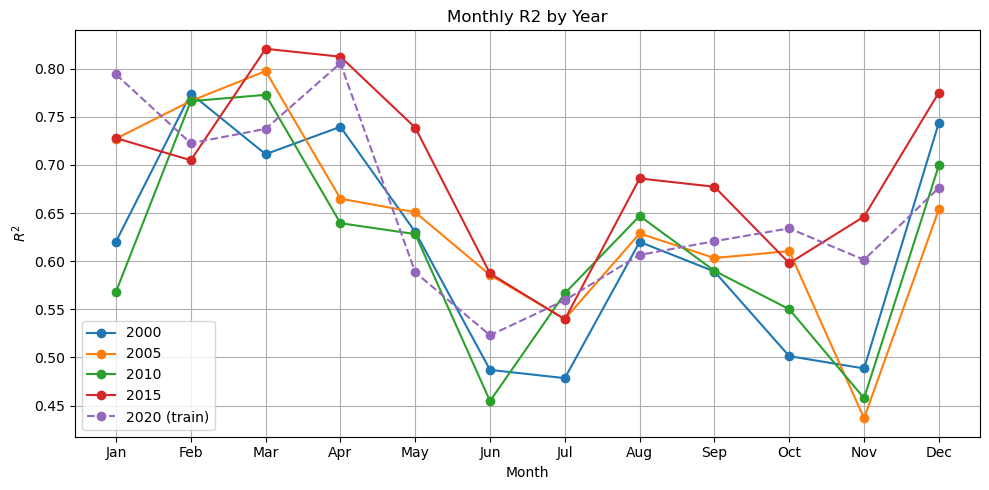

In [29]:
%%time
plot_metric_by_month(dataset, ['2000', '2005', '2010', '2015', '2020'], model, X_mean, X_std, num_var, cat_var, training_year="2020")

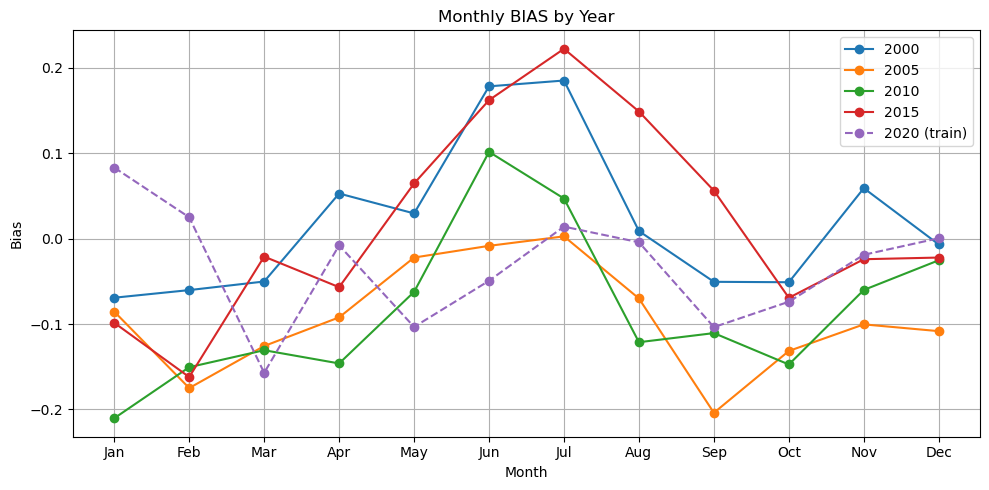

CPU times: user 17.2 s, sys: 2.22 s, total: 19.4 s
Wall time: 38.8 s


In [31]:
%%time
plot_metric_by_month(dataset, ['2000', '2005', '2010', '2015', '2020'], model, 
                     X_mean, X_std, num_var, cat_var, training_year="2020", metric="bias")

## Summary

That concludes the series on 2D CNNs for predicting chlorophyll in a region.

In [34]:
train_ds.time.values

array(['2015-01-01T00:00:00.000000000', '2015-01-03T00:00:00.000000000',
       '2015-01-05T00:00:00.000000000', '2015-01-07T00:00:00.000000000',
       '2015-01-08T00:00:00.000000000', '2015-01-09T00:00:00.000000000',
       '2015-01-10T00:00:00.000000000', '2015-01-11T00:00:00.000000000',
       '2015-01-12T00:00:00.000000000', '2015-01-14T00:00:00.000000000',
       '2015-01-15T00:00:00.000000000', '2015-01-16T00:00:00.000000000',
       '2015-01-17T00:00:00.000000000', '2015-01-18T00:00:00.000000000',
       '2015-01-19T00:00:00.000000000', '2015-01-21T00:00:00.000000000',
       '2015-01-23T00:00:00.000000000', '2015-01-28T00:00:00.000000000',
       '2015-01-30T00:00:00.000000000', '2015-02-01T00:00:00.000000000',
       '2015-02-02T00:00:00.000000000', '2015-02-07T00:00:00.000000000',
       '2015-02-08T00:00:00.000000000', '2015-02-09T00:00:00.000000000',
       '2015-02-10T00:00:00.000000000', '2015-02-11T00:00:00.000000000',
       '2015-02-13T00:00:00.000000000', '2015-02-15